In [47]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import argparse
import sys
sys.path.append(".")



- LOad images in with specific size 
- create modal with input size 
- maybe normalise images 
- binarize labels.

# Json FIles

In [84]:
def input_parse():
    # initialize the parser
    parser = argparse.ArgumentParser()
    parser.add_argument("--filepath", type=str) # argument is filepath as a string
    parser.add_argument("--train_sample_size", type = int, default = 91166)
    parser.add_argument("--val_sample_size", type = int, default = 7500)
    parser.add_argument("--test_sample_size", type = int, default = 7500)
    parser.add_argument("--epochs", type = int, default = 10)
    args = parser.parse_args()

    return args

In [72]:
def loading_metadata(args):
    print("Loading metadata to dataframes")
    test_metadata = pd.read_json(os.path.join( args.filepath, "metadata", "test_data.json"), lines=True) # Loading in JSON files of metadata
    train_metadata = pd.read_json(os.path.join(args.filepath, "metadata", "train_data.json"), lines=True)
    val_metadata = pd.read_json(os.path.join(args.filepath, "metadata", "val_data.json"), lines=True)
    return test_metadata, train_metadata, val_metadata

In [49]:
def sampling(test_metadata, train_metadata, val_metadata):
    test_metadata = test_metadata.sample(1000)
    train_metadata = train_metadata.sample(2000)
    val_metadata = val_metadata.sample(1000)
    return test_metadata, train_metadata, val_metadata

## Code with flow from dir

In [52]:
def image_data_generator():
    # Data augmentaion 
    # ImageDataGenerator from tensorflow 
    datagen = ImageDataGenerator(horizontal_flip=True, # Flip it horizontally around the access
                                rotation_range=20, # Rotate the image randomly 20 degress around the access
                                rescale = 1/255 # rescale it between 0-1
    )
    # Take your images, create a pipelie (Take an image modify it, pass it on)
    return datagen

In [53]:
def image_directory(args):
    main_dir = os.path.dirname(args.filepath)
    directory_images = main_dir # removing the last part of the specified filepath
    return directory_images

In [54]:
def training_images(train_metadata, directory_images):
    train_tf = datagen.flow_from_dataframe( # using keras flow  from dataframe 
        dataframe = train_metadata, # Defining dataframe 
        directory = directory_images, # Path to images 
        x_col = "image_path", # rest of the image path from dataframe 
        y_col = "class_label", # column label
        subset = "training", # what this data is 
        target_size=(224, 224), # image should be loaded in as size 
        color_mode="rgb", # colors 
        class_mode = "categorical", # One hot encoding the labels 
        batch_size = 128, # take images of batchs 128 at a time
        shuffle = True # shuffle the images around 
    )
    return train_tf

Found 2000 validated image filenames belonging to 15 classes.


In [55]:
def val_images(val_metadata, directory_images):
    val_tf = datagen.flow_from_dataframe(
        dataframe = val_metadata,
        directory = directory_images,
        x_col = "image_path",
        y_col = "class_label",
        #subset = "validation",
        target_size=(224, 224),
        color_mode="rgb",
        class_mode = "categorical",
        batch_size = 128,
        shuffle = True
    )
    return val_tf

Found 1000 validated image filenames belonging to 15 classes.


In [73]:
def test_image_generator():
    test_datagen = ImageDataGenerator(
                                    rescale = 1./255. # datagenerator for test, it only has to rescale the images 
    )
    return test_datagen

In [57]:
def test_images(test_metadata, directory_images):
    test_tf = test_datagen.flow_from_dataframe(
        dataframe = test_metadata,
        directory = directory_images,
        x_col = "image_path",
        target_size=(224, 224),
        color_mode="rgb",
        class_mode = None,
        batch_size = 128,
        shuffle = False # do not shuffle the images 
    )

Found 1000 validated image filenames.


# Model

In [58]:
def load_model():  
    # load model without classifier layers
    model = VGG16(include_top=False, 
                pooling='avg',
                input_shape=(224, 224, 3))

    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
        
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    bn = BatchNormalization()(flat1) # Added batnormalization from tensorflow. Take the previouslayer, normalise the values, and than pass them on
    class1 = Dense(256, 
                activation='relu')(bn) # Added new classification layer 
    class2 = Dense(128, 
                activation='relu')(class1)
    output = Dense(15, # 15 labels
                activation='softmax')(class2)

    # define new model
    model = Model(inputs=model.inputs, 
                outputs=output)

    # compile
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=10000,
        decay_rate=0.9)
    sgd = SGD(learning_rate=lr_schedule)

    model.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    # summarize
    print(model.summary())
    return model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Train model

In [59]:
def train_model(train_tf, val_tf, args):
    # fit the data generator to our images

    # fits the model on batches with real-time data augmentation:

    H = model.fit( # fitting the model to 
        train_tf, # training tensorflow dataframe 
        steps_per_epoch = len(train_tf), # take as many steps as the length of the dataframe 
        validation_data = val_tf, # Validation data 
        validation_steps = len(val_tf), 
        epochs = args.epochs
    )
    # Possible to get image (stream the image) (stream it frow the dataGenerator) from the folder, instead of loading the image into the script. 
    return H

Epoch 1/10


2023-04-26 21:34:45.993252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - ETA: 0s - loss: 2.7950 - accuracy: 0.0845 

2023-04-26 21:38:11.510401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 290s 18s/step - loss: 2.7950 - accuracy: 0.0845 - val_loss: 2.7381 - val_accuracy: 0.0710
Epoch 2/10
16/16 [==============================] - 121s 8s/step - loss: 2.5054 - accuracy: 0.1995 - val_loss: 2.7086 - val_accuracy: 0.0710
Epoch 3/10
16/16 [==============================] - 90s 6s/step - loss: 2.2947 - accuracy: 0.2960 - val_loss: 2.6756 - val_accuracy: 0.0760
Epoch 4/10
16/16 [==============================] - 91s 6s/step - loss: 2.1376 - accuracy: 0.3740 - val_loss: 2.6354 - val_accuracy: 0.0910
Epoch 5/10
16/16 [==============================] - 90s 6s/step - loss: 1.9786 - accuracy: 0.4225 - val_loss: 2.5916 - val_accuracy: 0.1040
Epoch 6/10
16/16 [==============================] - 89s 6s/step - loss: 1.8726 - accuracy: 0.4525 - val_loss: 2.5538 - val_accuracy: 0.1270
Epoch 7/10
16/16 [==============================] - 90s 6s/step - loss: 1.7584 - accuracy: 0.4920 - val_loss: 2.5018 - val_accuracy: 0.1660
Epoch 8/10
16/16 [==========

In [79]:
def plot_history(H, epochs, save_path):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(save_path, "loss_and_accuracy_curve.png"))

/tmp/ipykernel_1032/384103208.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


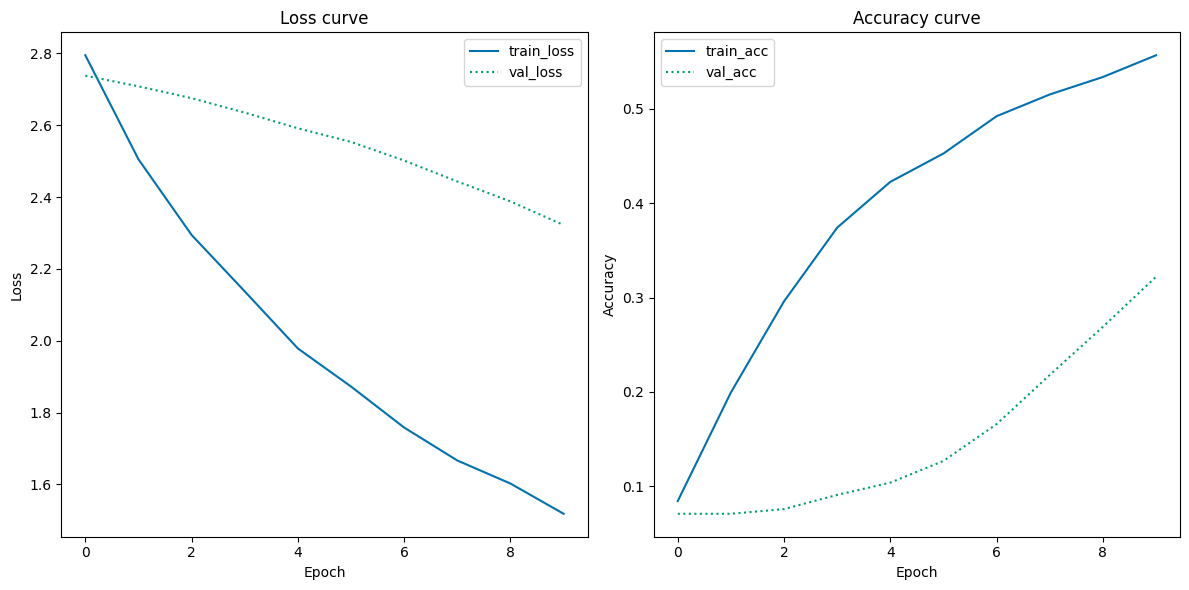

In [80]:
def plot_model_history(H, args. save_path):
    save_path = os.path.join("..", "figs")
    plot_history(H, 10, save_path)


code taken from https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

In [82]:
def prediction(test_tf, train_tf):
    # Predict the label of the test_images
    pred = model.predict(test_tf)
    pred = np.argmax(pred,axis=1)

    # Map the label 
    labels = (train_tf.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred1 = [labels[k] for k in pred]
    retun pred, pred1
    # Display the result
    #print(f'The first 5 predictions: {pred[:20]}')

2023-04-26 22:47:33.933191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 60s 8s/step


NameError: name 'train_tf' is not defined

Obtain the true classes for your test or validation data:

Generate the classification report for the test or validation data:

In [64]:
def classification_report_function(test_metadata, pred):
    y_true = test_metadata['class_label'].values
    classification_report_test = classification_report(y_true, pred)
    print("Classification Report - Test Data:")
    print(classification_report_test)



Classification Report - Test Data:
                      precision    recall  f1-score   support

              blouse       0.85      0.68      0.75        59
         dhoti_pants       0.00      0.00      0.00        74
            dupattas       0.25      0.06      0.09        71
               gowns       0.36      0.31      0.33        68
           kurta_men       0.38      0.08      0.14        61
leggings_and_salwars       0.35      0.76      0.48        78
             lehenga       0.89      0.32      0.47        76
         mojaris_men       0.00      0.00      0.00        70
       mojaris_women       0.53      0.74      0.61        68
       nehru_jackets       0.51      0.43      0.47        56
            palazzos       0.43      0.18      0.26        65
          petticoats       1.00      0.12      0.21        60
               saree       0.44      0.66      0.53        68
           sherwanis       1.00      0.01      0.03        71
         women_kurta       0.13   

/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
args = parser.parse_args(['--filepath', './././images', '--train_sample_size', '1000', "--val_sample_size", "100", "--test_sample_size", "100"])

NameError: name 'parser' is not defined

In [ ]:
def mainfunction():
  args = input_parse()
  test_metadata, train_metadata, val_metadata = loading_metadata(args)
  test_metadata, train_metadata, val_metadata = sampling(test_metadata, train_metadata, val_metadata)
  datagen = image_data_generator()
  directory_images = image_directory()
  train_tf = training_images(train_metadata, directory_images)
  val_tf = val_images(val_metadata, directory_images)
  test_datagen = test_image_generator()
  test_tf = test_images(test_metadata, directory_images)
  model = load_model():
  H = train_model(train_tf, val_tf, args)
  plot_history(H, epochs)
  plot_model_history(H, args, save_path)
  pred, pred1 = predictions(test_tf, train_tf)
  classification_report_function(test_metadata, pred)


# filepath "..", "..", "..", "images"